# [COM3240] Lab 7: Reinforcement Learning on MNIST dataset

## Overview

We will use again the MNIST datasets, but in this case we will train two perceptrons, one with supervised learning and the other through RL.

For the training loop with RL, a reward of 1 is delivered if the correct action (the output that corresponds to the input image) is taken, and the reward will be zero otherwise. This is an example of an environment with immediate rewards, because the agent makes an action and receives a reward after presentation of an input image.

The difference between RL and supervised learning is depicted below.


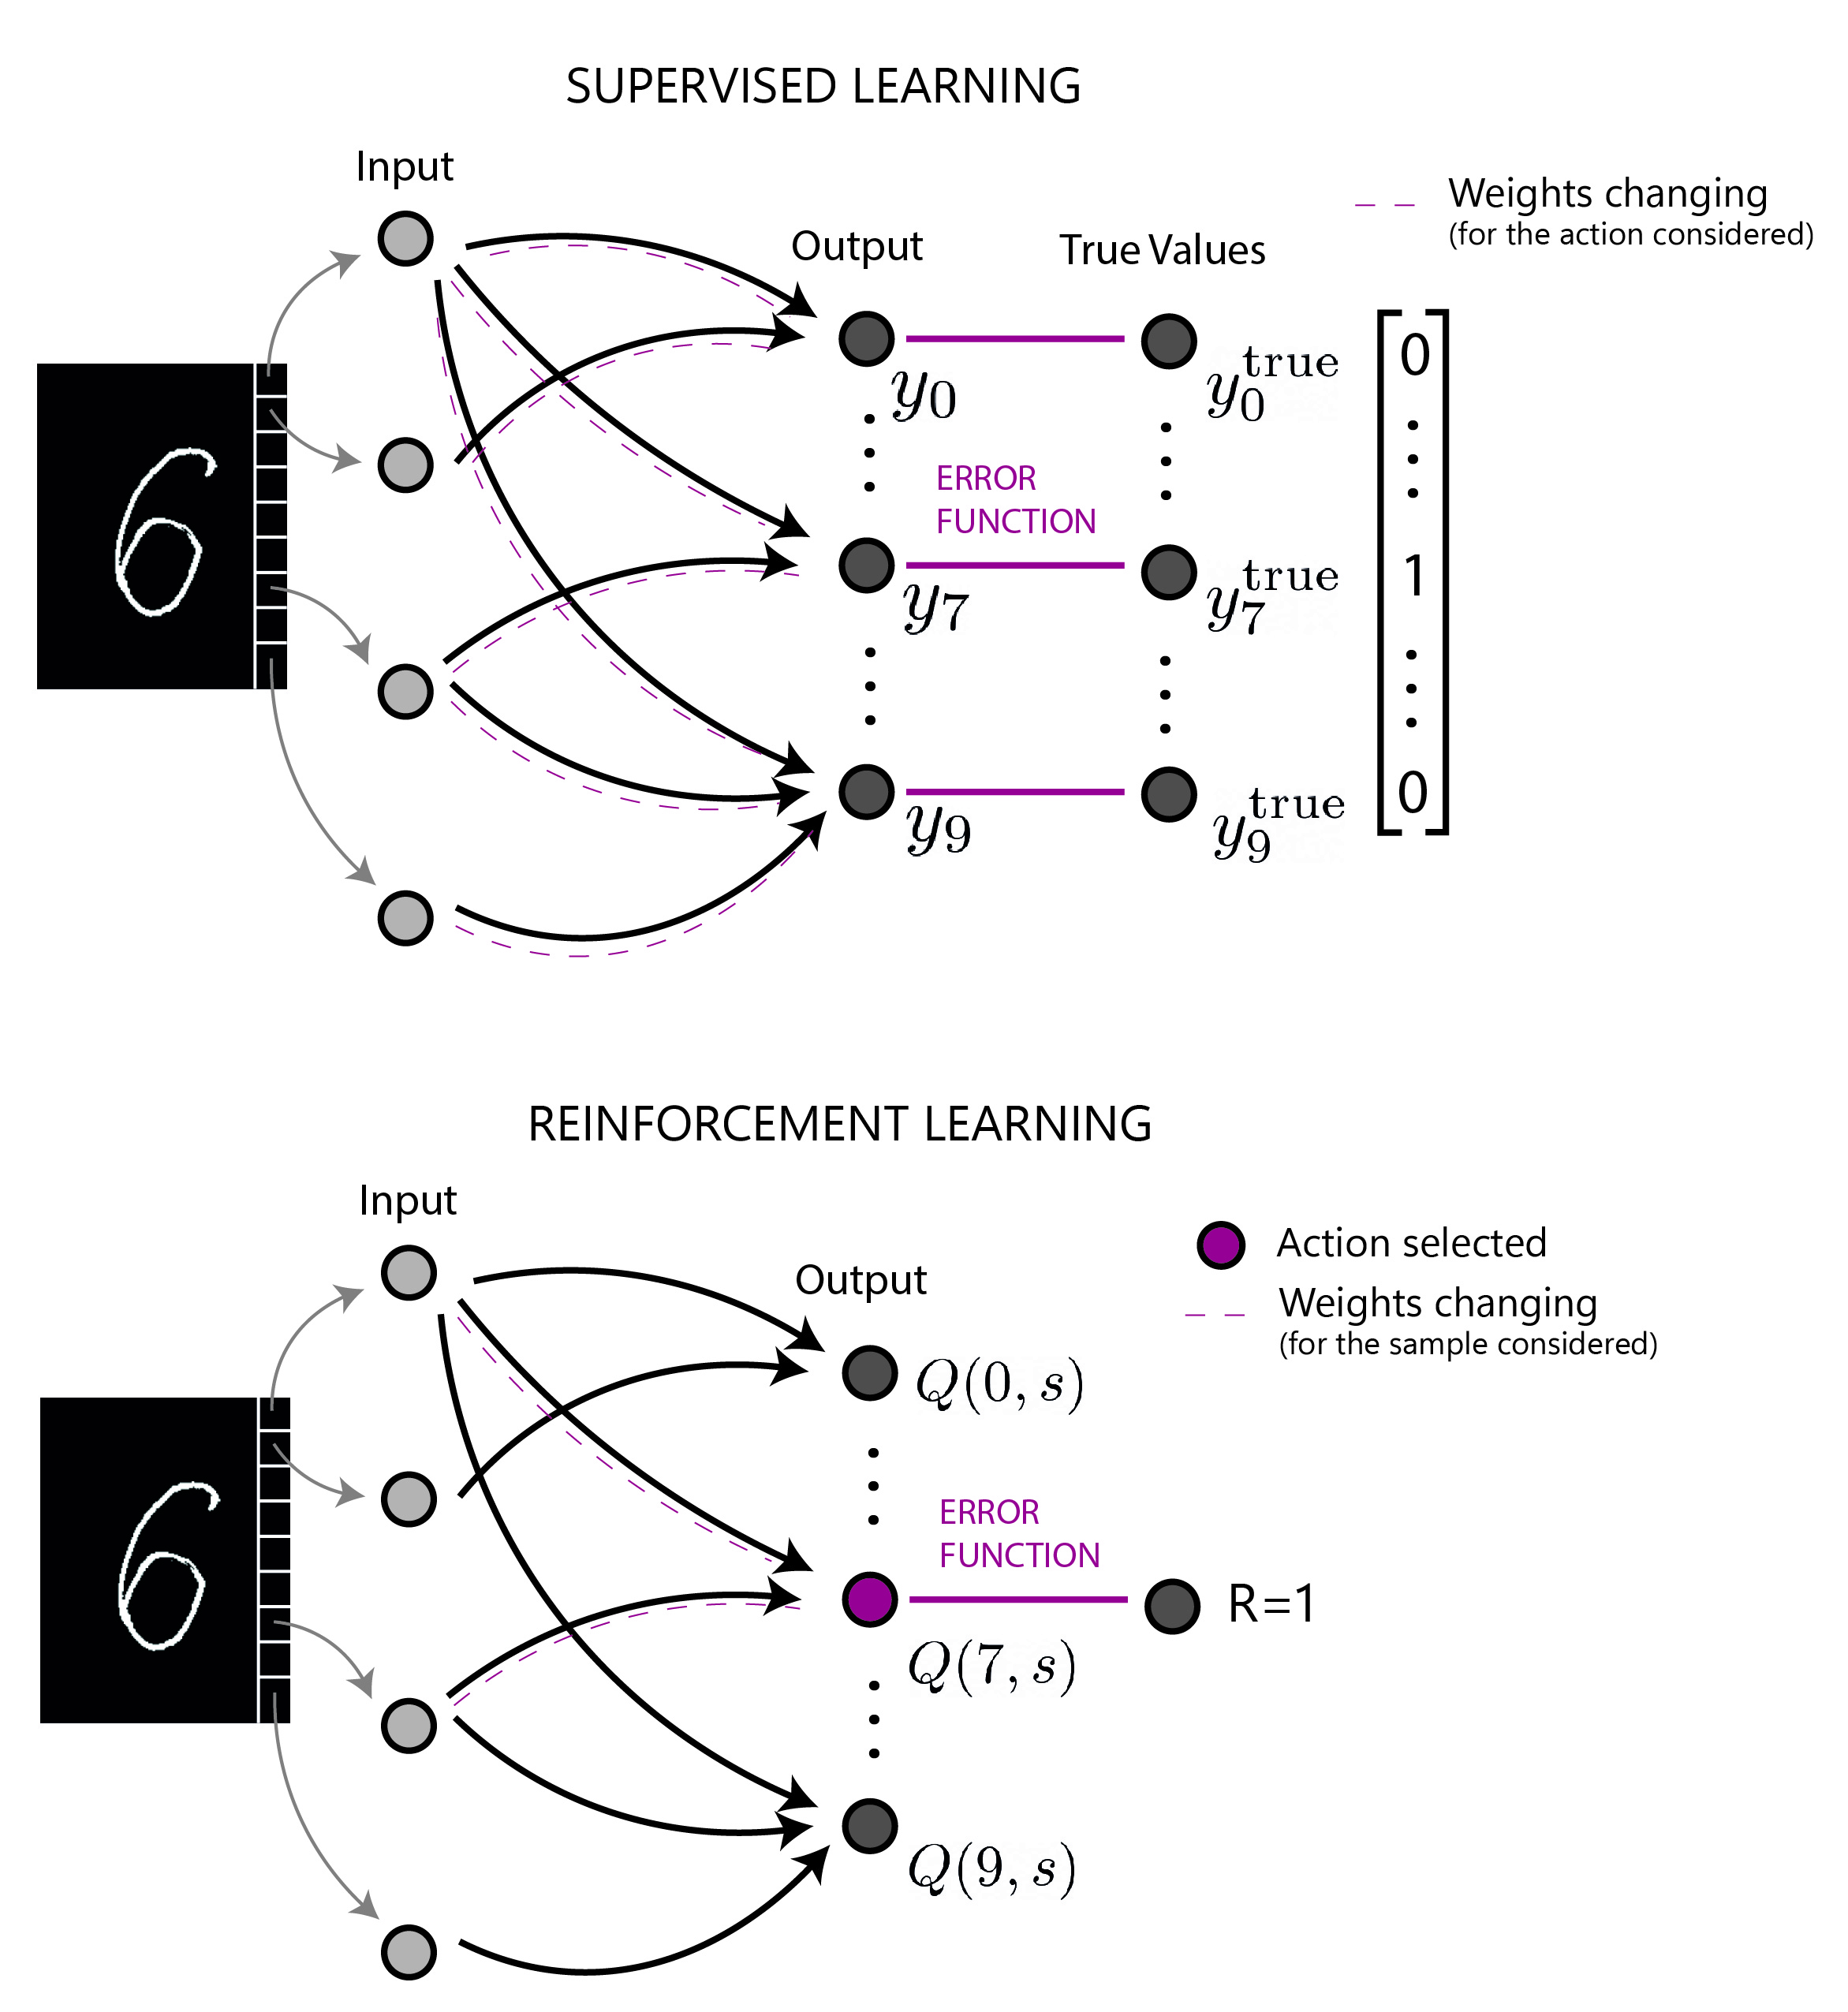

### Exercises

**1. Understand the code**
- Study the code and understand how it works

**2. Implement the code for Reinforcement Learning**
- Implement the code for the RL training loop on the MNIST dataset
- See 'TODO1' in code comments

**3. Check perfomance of RL algorithm during training**
- You will need to compute the performance on both the training and testing set
- See 'TODO2' and 'TODO3' in the code comments

**3.1. Print and save the average performance obtained in exercise 3**
- See 'TODO4' in the comments

**4. Plot the average reward for RL**
- See 'TODO5' in the comments

**5. Given the performance of the RL model after training using a greedy policy, what is the accuracy for an epsilon greedy policy?**

**6. If you increase the number of output classes, how will RL perform in comparison to supervised learning?**

**7. Use Adam for the simulation**
- implement the Adam Optimizer, see notebook 'Adam_s playground with note.ipynb'

**7.1. After implementing Adam, run the algorithm with 10 classes**

## Loading the Dataset

In [1]:
import numpy as np;
import numpy.matlib 
import math
import matplotlib.pyplot as plt
import csv

In [2]:
# Load the MNIST dataset:

from scipy.io import loadmat

mnist = loadmat('MNIST.mat')

# Read the train set
x_train = mnist['x_train']
# Read the train labels
trainlabels = mnist['trainlabels']

# Read the test set
x_test = mnist['x_test']
# Read the test labels
testlabels = mnist['testlabels']

#We select the data for N_class (in this case 5) classes that we want to classify

N_class=5

Index_tr=[]
Index_te=[]

for i in range(N_class):
    
    #Find the indexes of the training set corresponding to class i
    ind_tr=np.where(trainlabels==i)[0]
    #Find the indexes of the test set corresponding to class i
    ind_te=np.where(testlabels==i)[0]
    
    # Append the training indexes in a list
    Index_tr.append(ind_tr)
    # Append the testing indexes in a list
    Index_te.append(ind_te)

# Reshape the lists to be a 1-d array    
Index_tr=np.concatenate(Index_tr,axis=0)
Index_te=np.concatenate(Index_te,axis=0)

# Create a training set and a test set with data belonging to the classes considered only
X_tr=np.copy(x_train[Index_tr,:])
X_te=np.copy(x_test[Index_te,:])

# Compute the size of the train and test datasets
N_tr=np.shape(Index_tr)[0]
N_te=np.shape(Index_te)[0]

# Create one-hot encoding labels for train and test datasets
Y_tr=np.zeros([N_tr,N_class])
Y_te=np.zeros([N_te,N_class])

for i in range(N_tr):
    
    Y_tr[i,int(trainlabels[Index_tr[i]])]=1

for i in range(N_te):

    Y_te[i,int(testlabels[Index_te[i]])]=1



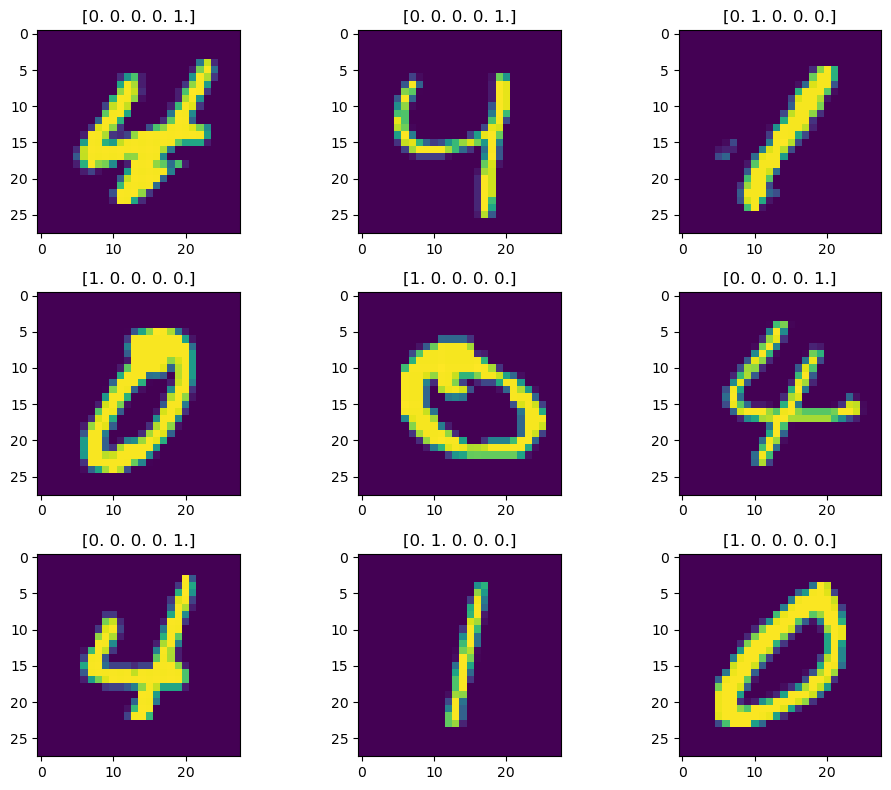

In [3]:
# Let's plot some examples

N_image_r=3

fig, axs = plt.subplots(N_image_r, N_image_r,figsize=(10,8))

for i in range(N_image_r):
    for j in range(N_image_r):
        
        random_ind=np.random.randint(0,N_tr)
        example_image=np.reshape(X_tr[random_ind],(28,28))
        
        axs[i,j].imshow(example_image.T)
        axs[i,j].title.set_text(np.array2string(Y_tr[random_ind,:]))

plt.tight_layout()

## Note: Matrix multiplication, avoiding for loops

For this exercise, we will consider a different method to compute the network's activities and the gradients. 
In the previous lab (Lab1), we have used for loops to compute the response of the system for each sample in the minibatch.
Now, we will be using matrix multiplications. 

As in standard tools like Tensorflow and Pytorch, the first dimension will always be the dimension containing the different samples in the minibatch. Thus, our input $\mathbf{x}$ will be of shape $[batch_{size},784]$ for the minibatch considered. 

Then, performing matrix multiplications $\mathbf{x}\mathbf{W}$ (notice that the weights are of shape $[784,N_{class}]$) we will get outputs of shapes $[batch_{size},N_{class}]$ for all the samples in the minibatch at once. 

Finally, we will perform the updates of the parameters in a similar fashion.



## Implementing the Training Loops

In [4]:
## Definition of the epsilon-greedy policy. Notice that the shape of the Qvalues (input to the function) should be 
## [batch_size,N_actions]

def EpsilonGreedy_Policy(Qvalues, epsilon):
    

    N_class=np.shape(Qvalues)[1]
    batch_size=np.shape(Qvalues)[0]

    rand_values=np.random.uniform(0,1,[batch_size])

    rand_a=rand_values<epsilon
    a=np.zeros([batch_size,N_class])

    for i in range(batch_size):

        if rand_a[i]==True:

            a[i,np.random.randint(0,N_class)]=1

        else:

            a[i,np.argmax(Qvalues[i])]=1
            
    return a

## What is the probability of selecting the best action?
## Theoretically, it is (1-epsilon)+epsilon*1/N_class, 
## where the first term corresponds to selecting the greedy action, 
## while the second term corresponds to selecting a random action that corresponds to the greedy action
## Let' s check that this is true

epsilon=0.4

# Generate 100000 Q-values
Qvalues=np.random.randn(100000,N_class)

# Greedy policy
greedy=np.argmax(Qvalues,1)

# Epsilon-greedy policy
actions=EpsilonGreedy_Policy(Qvalues,epsilon)

print('Theoretical: ', 1/N_class*epsilon+(1-epsilon), 'Model: ',  np.mean(greedy==np.argmax(actions,1)))

Theoretical:  0.6799999999999999 Model:  0.67886


In [5]:
## Hyperparameters

N_minibatch=10000
batch_size=10

n_input=np.shape(X_tr)[1]

eta=0.0005
epison=0.4


In [6]:
## WE HAVE TWO PERCEPTRONS, ONE TRAINED WITH RL AND THE OTHER WITH SUPERVISED LEARNING
## YOU WILL HAVE TO TRAIN THE RL NETWORK AND PLOT THE AVERAGE REWARD AS TRAINING PROGRESSES
## THE CODE FOR THE SUPERVISED LEARNING NETWORK HAS BEEN GIVEN
## PLEASE NOTE THAT IN RL YOU NEED TO UPDATE ONLY THE PARAMETERS CORRESPONDING TO THE ACTIONS TAKEN

# Let's initialise the weights and the bias for the perceptron  
W=np.random.randn(n_input,N_class)/np.sqrt(n_input)
b=np.zeros([1,N_class])

# Let's create a copy of the parameters to be optimised with supervised learning
W_sp=np.copy(W)
b_sp=np.copy(b)


## Define after how many minibatches we will compute the performance 
N_check=100

## Number of times in which we will compute the performance
N_perf=int(np.round(N_minibatch/N_check))

Accuracy=np.zeros([2,N_perf])
Average_R=np.zeros([2,N_perf])

In [7]:
## Training Loop
for n in range(N_minibatch):
        
    ## Let's select batch_size training images, which are sampled randomly from the dataset
    
    batch_ind=np.random.randint(0,N_tr,[batch_size])
    
    # The input, of shape [batch_size,784]
    x=np.copy(X_tr[batch_ind,:])
    
    # The desired output (in one hot encoding), of shape [batch_size,3]
    y_true=np.copy(Y_tr[batch_ind,:])
    
    ## SUPERVISED LEARNING #############################################
    
    # Computation of the network's output for all the sampled images  
    # The outputs should have shape [batch_size,N_class], that is N_class outpit dimensions for all the batch_size sampled images
    # Given that x has shape [batch_size,784] and W has shape [batch_size,N_class], np.matmul(x,W) has shape [batch_size,N_class]
    # To add the bias which has shape [1,N_class], we need to replicate its value batch_size times across the firs dimension
    y=np.matmul(x,W_sp)+np.tile(b_sp,[batch_size,1])
    
    delta_sp=(y_true-y)
    
    # np.transpose(x) is of size [784,batch_size], while delta is of size [batch_size,N_class]. 
    # Their product is of size [784,N_class] and gives us exatly the delta for the weights, summing the samples in the minibatch.
    delta_W_sp=np.matmul(np.transpose(x),delta_sp)
    
    # delta_b is the sum of the delta [minbatch,N_class] across the minibatch, to obtain the shape of the bias [1,N_class]
    delta_b_sp=np.expand_dims(np.sum(delta_sp,0),0)
    
    W_sp=W_sp+eta*delta_W_sp
    b_sp=b_sp+eta*delta_b_sp
    
    ## REINFORCEMENT LEARNING ###########################################
    
    # TODO1: FILL YOUR CODE FOR REINFORCEMENT LEARNING
    
    ## CHECK PERFORMANCE ################################################
    # Every N_check iterations we compute the performance of the two networks, one trained with supervised learning and the other 
    # with RL. For RL, we will use the greedy policy while testing, to exploit and report the accuracy.
    if n%N_check==0:
        
        x=np.copy(X_tr)
        y_true=np.copy(Y_tr)
        
        ## SUPERVISED LEARNING ########
        # Performance on training set
        y=np.matmul(x,W_sp)+np.tile(b_sp,[N_tr,1])
        selected_outs=np.argmax(y,1)
        
        Correct_tr=np.int32(np.argmax(y_true,1)==selected_outs)
        
        # Performance on testing set
        x=np.copy(X_te)
        y_true=np.copy(Y_te)
        
        y=np.matmul(x,W_sp)+np.tile(b_sp,[N_te,1])
        selected_outs=np.argmax(y,1)
        
       
        Correct_te=np.int32(np.argmax(y_true,1)==selected_outs)
        
        # Print & save the average rewards
        print('Minibatch number {} SUPERVISED LEARNING ACCURACY for Train {} and Test {}'.format(n, np.mean(Correct_tr),np.mean(Correct_te)))

        ind_save=int(n/N_check)
        Accuracy[0,ind_save]=np.mean(Correct_tr)
        Accuracy[1,ind_save]=np.mean(Correct_te)
        
        ## REINFORCEMENT LEARNING ########
        ## TODO2: FILL YOUR CODE TO COMPUTE THE RL PERFORMANCE ON THE TRAINING SET
        
        ## TODO3: FILL YOUR CODE TO COMPUTE THE RL PERFORMANCE ON THE TESTING SET
        
        ## TODO4: PRINT & SAVE THE AVERAGE REWARDS
        

Minibatch number 0 SUPERVISED LEARNING ACCURACY for Train 0.1717544777095045 and Test 0.16832068495816307
Minibatch number 100 SUPERVISED LEARNING ACCURACY for Train 0.8420054909138449 and Test 0.848024907569566
Minibatch number 200 SUPERVISED LEARNING ACCURACY for Train 0.8931559681004053 and Test 0.8972562755399883
Minibatch number 300 SUPERVISED LEARNING ACCURACY for Train 0.9092038174924827 and Test 0.914380229616657
Minibatch number 400 SUPERVISED LEARNING ACCURACY for Train 0.9191724408419402 and Test 0.930725822144386
Minibatch number 500 SUPERVISED LEARNING ACCURACY for Train 0.9213295855667407 and Test 0.9289745086592722
Minibatch number 600 SUPERVISED LEARNING ACCURACY for Train 0.9246633546868872 and Test 0.9299474605954466
Minibatch number 700 SUPERVISED LEARNING ACCURACY for Train 0.9292391162243431 and Test 0.9379256664720763
Minibatch number 800 SUPERVISED LEARNING ACCURACY for Train 0.9298927964439796 and Test 0.9334500875656743
Minibatch number 900 SUPERVISED LEARNING 

Minibatch number 8200 SUPERVISED LEARNING ACCURACY for Train 0.9458099097921296 and Test 0.9455146915742363
Minibatch number 8300 SUPERVISED LEARNING ACCURACY for Train 0.9434566610014381 and Test 0.9441525588635922
Minibatch number 8400 SUPERVISED LEARNING ACCURACY for Train 0.9447640214407113 and Test 0.9451255107997665
Minibatch number 8500 SUPERVISED LEARNING ACCURACY for Train 0.9474767943522029 and Test 0.9490173185444639
Minibatch number 8600 SUPERVISED LEARNING ACCURACY for Train 0.9479343705059485 and Test 0.9527145359019265
Minibatch number 8700 SUPERVISED LEARNING ACCURACY for Train 0.9443718133089293 and Test 0.9478497762210547
Minibatch number 8800 SUPERVISED LEARNING ACCURACY for Train 0.9464635900117663 and Test 0.9490173185444639
Minibatch number 8900 SUPERVISED LEARNING ACCURACY for Train 0.9481304745718394 and Test 0.9527145359019265
Minibatch number 9000 SUPERVISED LEARNING ACCURACY for Train 0.9395999477055824 and Test 0.9388986184082506
Minibatch number 9100 SUPERV

## Plotting

Text(0, 0.5, 'Accuracy (Supervised) and Average reward (Reinforcement)')

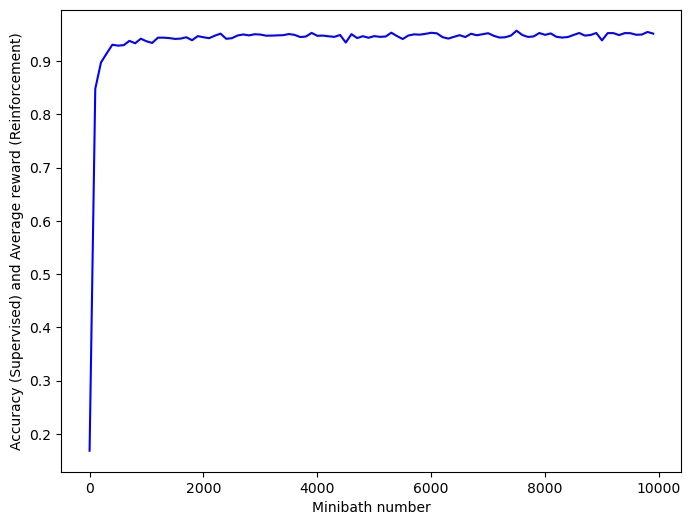

In [8]:
fig, axs = plt.subplots(1,figsize=(8,6))

# plotting the accuracy for the supervised learning algorithm on the test set
plt.plot(np.arange(0,N_perf)*N_check,Accuracy[1,:],'b')

# TODO5: PLOT THE RL AVERAGE REWARD

# plot labels
plt.xlabel('Minibath number')
plt.ylabel('Accuracy (Supervised) and Average reward (Reinforcement)')